Verify the torch and detectron versions

In [1]:
import sys, os
sys.path.insert(0, os.path.abspath('./detectron2'))
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Nov__3_17:51:05_Pacific_Daylight_Time_2023
Cuda compilation tools, release 12.3, V12.3.103
Build cuda_12.3.r12.3/compiler.33492891_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(1)
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 1
Count of using GPUs: 4


Import the required libraries

In [3]:
from detectron2.utils.logger import setup_logger
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data import build_detection_test_loader
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import json, cv2, random, yaml

import matplotlib.patches as patches

setup_logger()


<Logger detectron2 (DEBUG)>

In [4]:
# Display images with COCO annotations
def display_images_with_coco_annotations(image_paths, annotations, display_type='both'):
    fig, axs = plt.subplots(4, 2, figsize=(10, 10))
    overlay_dir = r'D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\overlay'
  
    for img_ax, overlay_ax, img_path in zip(axs[:, 0].ravel(), axs[:, 1].ravel(), image_paths):
        # Load image using OpenCV and convert it from BGR to RGB color space
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        img_ax.imshow(image)
        img_ax.axis('off')  # Turn off the axes

        # Get image filename to match with annotations
        img_filename = os.path.basename(img_path)
        img_id = next(item for item in annotations['images'] if item["file_name"] == img_filename)['id']
        
        # Filter annotations for the current image
        img_annotations = [ann for ann in annotations['annotations'] if ann['image_id'] == img_id]
        
        # Generate random colors for each annotation
        # colors = [tuple(np.random.rand(3)) for _ in img_annotations]
        colors = [(0, 0, 0)] * len(img_annotations)


        for ann, color in zip(img_annotations, colors):
            # Display bounding box
            if display_type in ['bbox', 'both']:
                bbox = ann['bbox']
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], 
                                         linewidth=1, edgecolor=color, 
                                         facecolor='none')
                img_ax.add_patch(rect)
            
            # Display segmentation polygon
            if display_type in ['seg', 'both']:
                for seg in ann['segmentation']:
                    poly = [(seg[i], seg[i+1]) for i in range(0, len(seg), 2)]
                    polygon = patches.Polygon(poly, closed=True, edgecolor=color, 
                                              fill=False)
                    img_ax.add_patch(polygon)
                    
        img_name = os.path.basename(img_path)
        img_name = img_name.replace('.png', '.jpg')    

        print('img_name:', img_name)

        # find the corresponding overlay image from the overlay directory
        for root, _, files in os.walk(overlay_dir):
            for file in files:
                if img_name in file:
                    overlay_file_dir = os.path.join(root, file)
                    print(overlay_dir)
                    break

        # read image
        overlay = cv2.imread(overlay_file_dir)
        overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
        
        overlay_ax.imshow(overlay)
        overlay_ax.axis('off')  # Turn off the axes

    plt.tight_layout()
    plt.show()

['D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train\\crag_3_6.png', 'D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train\\crag_46_1.png', 'D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train\\crag_38_3.png', 'D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train\\crag_9_7.png']
img_name: crag_3_6.jpg
D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\overlay
img_name: crag_46_1.jpg
D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\overlay
img_name: crag_38_3.jpg
D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\overlay
img_name: crag_9_7.jpg
D:\hjkwak\PROJ_Nuclei_Segmentation\Lizard_Dataset\overlay


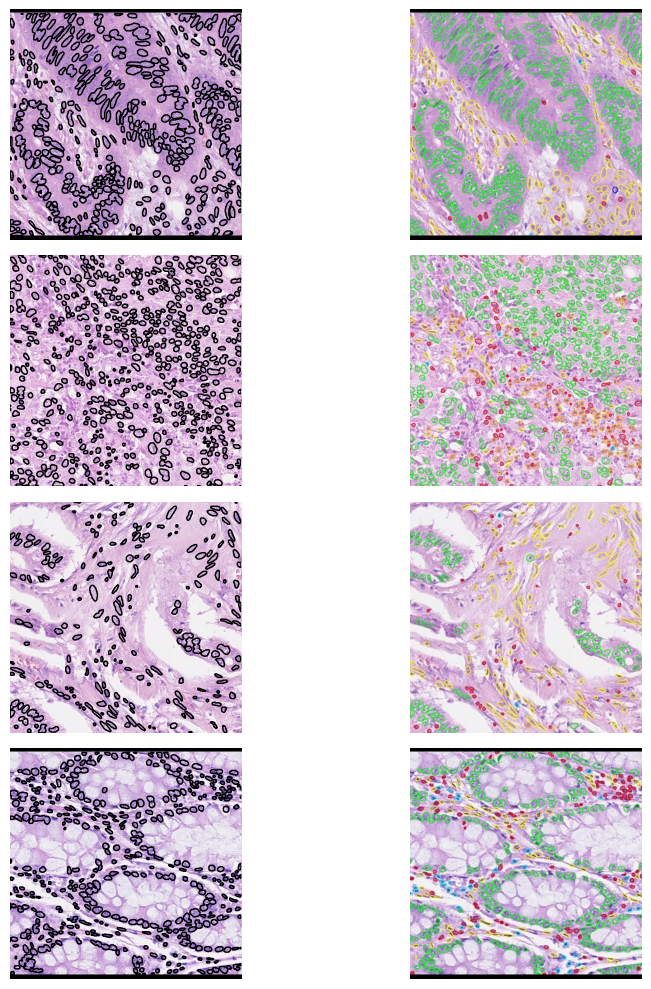

In [5]:
''' Check if the data is processed correctly '''
with open('D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train/coco_annotations.json', 'r') as f:
    annotations = json.load(f)

# Get all image files
image_dir = "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train"
all_image_files = [os.path.join(image_dir, img['file_name']) for img in annotations['images']]
random_image_files = random.sample(all_image_files, 4)
print(random_image_files)

# Choose between 'bbox', 'seg', or 'both'
display_type = 'seg'
display_images_with_coco_annotations(random_image_files, annotations, display_type)


Register datasets in the COCO format

In [6]:
register_coco_instances("dataset_train",
                        {},
                        "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train/coco_annotations.json",
                        "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train"
                        )

register_coco_instances("dataset_val",
                        {},
                        "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/val/coco_annotations.json", 
                        "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/val"
                        )

register_coco_instances("dataset_test", 
                        {}, 
                        "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/test/coco_annotations.json", 
                        "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/test"
                        )



In [7]:
train_metadata = MetadataCatalog.get("dataset_train")
train_dataset_dicts = DatasetCatalog.get("dataset_train")

val_metadata = MetadataCatalog.get("dataset_val")
val_dataset_dicts = DatasetCatalog.get("dataset_val")

test_metadata = MetadataCatalog.get("dataset_test")
test_dataset_dicts = DatasetCatalog.get("dataset_test")

[05/16 13:24:43 d2.data.datasets.coco]: Loading D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train/coco_annotations.json takes 2.34 seconds.
[05/16 13:24:43 d2.data.datasets.coco]: Loaded 618 images in COCO format from D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/train/coco_annotations.json
[05/16 13:24:44 d2.data.datasets.coco]: Loaded 178 images in COCO format from D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/val/coco_annotations.json
[05/16 13:24:45 d2.data.datasets.coco]: Loaded 88 images in COCO format from D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/test/coco_annotations.json


Visualize some random images - Sanity check

In [8]:
# # Visualize some random samples
# import matplotlib.pyplot as plt
# import logging

# plt.rcParams['figure.figsize'] = [10, 5]
# logging.getLogger('matplotlib').setLevel(logging.WARNING)

# for d in random.sample(train_dataset_dicts, 2):
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
#     vis = visualizer.draw_dataset_dict(d)
#     plt.imshow(vis.get_image()[:, :, ::-1])
#     plt.show()

Train

In [9]:
cfg = get_cfg()
cfg.OUTPUT_DIR = "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models/patches_removedOutliers"
cfg.merge_from_file(model_zoo.get_config_file(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    ))
cfg.DATASETS.TRAIN = ("dataset_train",)
cfg.DATASETS.TEST = ("dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
    )  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2  # This is the real "batch size" commonly known to deep learning people
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 15000
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # Default is 512, using 256 for this dataset.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 1 classes. (Nuclei)
# NOTE: this config means the number of classes, without the background. Do not use num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given congiguration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available


[05/16 13:25:01 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

In [10]:
trainer.train() #Start the training process

[05/16 13:25:04 d2.engine.train_loop]: Starting training from iteration 0


c:\Users\hjkwak\anaconda3\envs\pt-base\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[05/16 13:25:12 d2.utils.events]:  eta: 0:33:32  iter: 19  total_loss: 8.268  loss_cls: 0.7074  loss_box_reg: 0.102  loss_mask: 0.6932  loss_rpn_cls: 6.156  loss_rpn_loc: 0.6665    time: 0.1487  last_time: 0.1239  data_time: 0.1556  last_data_time: 0.0023   lr: 4.9953e-06  max_mem: 3437M
[05/16 13:25:15 d2.utils.events]:  eta: 0:32:44  iter: 39  total_loss: 5.936  loss_cls: 0.6634  loss_box_reg: 0.1669  loss_mask: 0.6904  loss_rpn_cls: 3.727  loss_rpn_loc: 0.6435    time: 0.1400  last_time: 0.1301  data_time: 0.0029  last_data_time: 0.0020   lr: 9.9902e-06  max_mem: 3960M
[05/16 13:25:18 d2.utils.events]:  eta: 0:32:28  iter: 59  total_loss: 3.271  loss_cls: 0.6147  loss_box_reg: 0.2387  loss_mask: 0.6844  loss_rpn_cls: 1.128  loss_rpn_loc: 0.5783    time: 0.1362  last_time: 0.1308  data_time: 0.0029  last_data_time: 0.0031   lr: 1.4985e-05  max_mem: 3960M
[05/16 13:25:20 d2.utils.events]:  eta: 0:32:17  iter: 79  total_loss: 2.613  loss_cls: 0.562  loss_box_reg: 0.2762  loss_mask: 0.6

Checkout training metrics using tensorboard

In [11]:
# Look at training curves in tensorboard:
%load_ext tensorboard
# %reload_ext tensorboard  #Reload in case you have already loaded it once

%tensorboard --logdir D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models/patches_removedOutliers --port 6007


Save the model and yaml file for future use.

In [12]:
# Save the configuration to a config.yaml file
config_yaml_path = "D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models/patches_removedOutliers/original_config-15k_iter.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

#Save the model weights with a different name so we don't accidentally overwrite our model.
os.rename(os.path.join(cfg.OUTPUT_DIR, "model_final.pth"), os.path.join(cfg.OUTPUT_DIR, "original_15k_iter.pth"))

Inference & evaluation

In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "original_15k_iter.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2   # set a custom threshold

predictor = DefaultPredictor(cfg)


[05/16 14:17:57 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/models/Detectron2_Models/patches_removedOutliers\original_15k_iter.pth ...


Verify segmentation on random test images

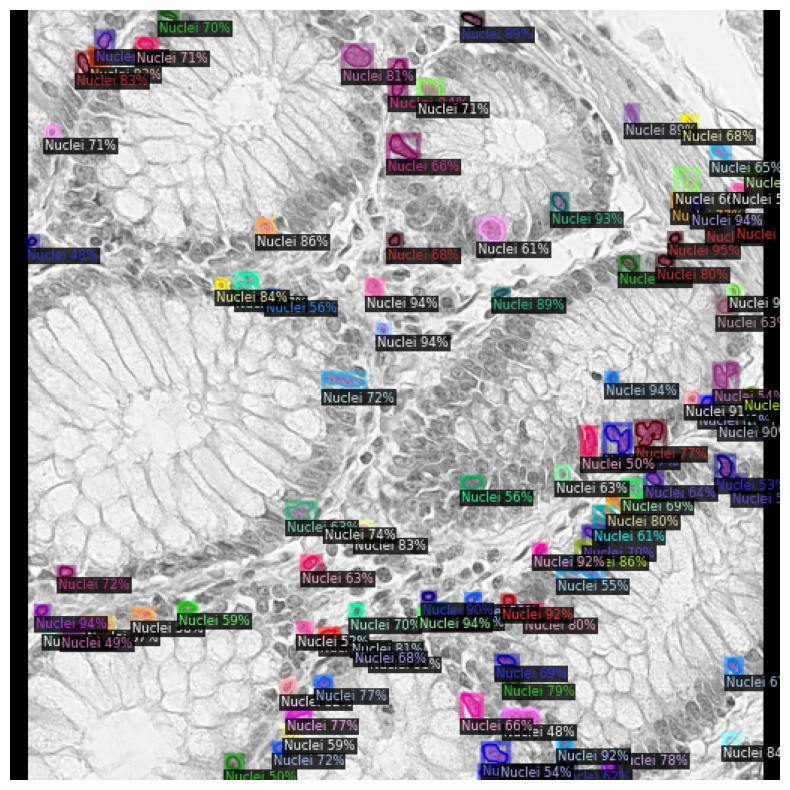

crag_11_5.png


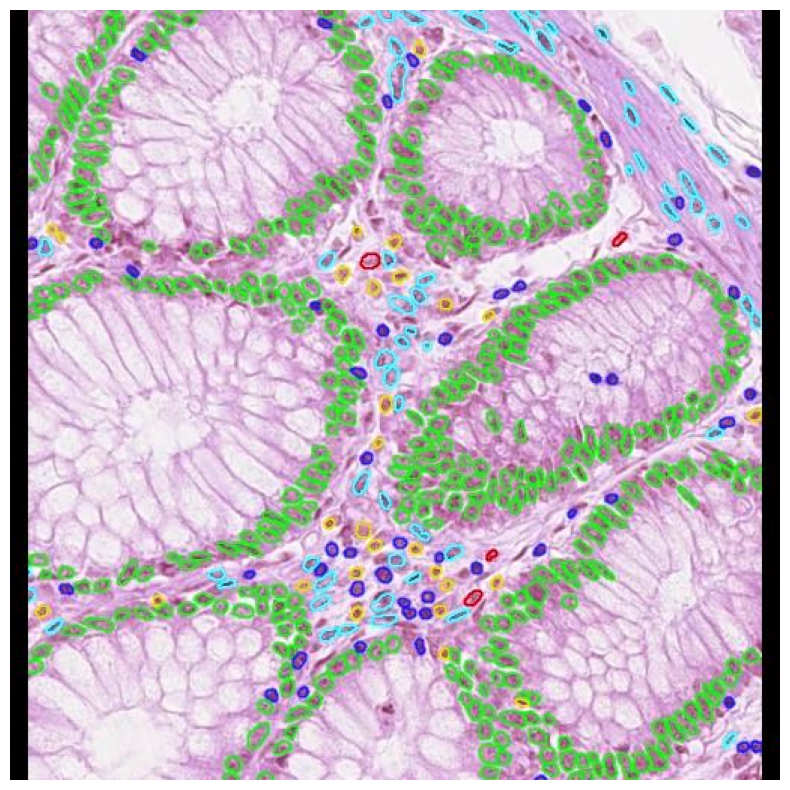

In [21]:
for d in random.sample(test_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=1,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # cv2_imshow(im[:, :, ::-1])
    # cv2_imshow(out.get_image()[:, :, ::-1])
    
    plt.figure(figsize=(10, 10))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()

    # compare with the ground truth
    file_name = d["file_name"].split("\\")[-1]
    print(file_name)
    if file_name.endswith(".png"):
        file_name = file_name[:-4] + ".jpg"
    img = cv2.imread(f"D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/overlay/Overlay_patches/{file_name}")
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

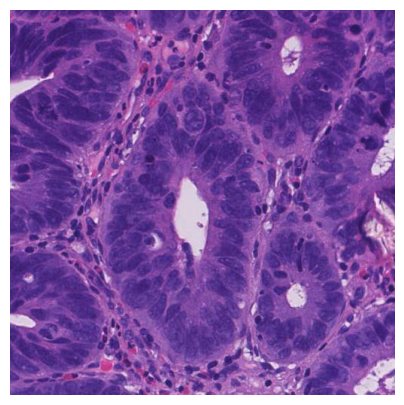

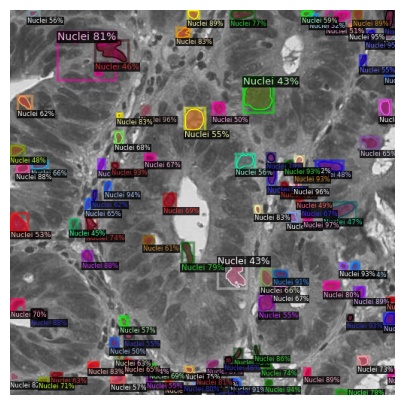

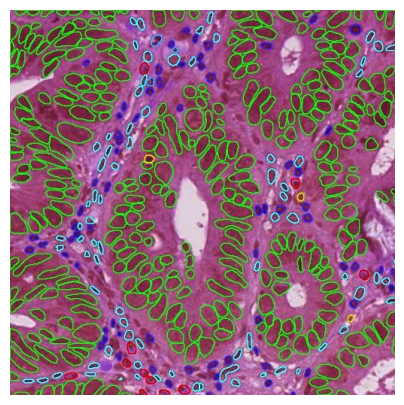

In [22]:
for d in random.sample(test_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs2 = predictor(im)

    # Perform prediction on the tile using your trained model
    outputs2 = predictor(im)

# Get the confidence scores
    scores = outputs2["instances"].scores

# Define your custom threshold
    threshold = 0.1

# Filter instances based on confidence threshold
    filtered_indices = [i for i, score in enumerate(scores) if score > threshold]

# Update the instances in the outputs
    outputs2["instances"] = outputs2["instances"][filtered_indices]

    v = Visualizer(im[:, :, ::-1],
                   metadata=test_metadata,
                   scale=1,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs2["instances"].to("cpu"))

    # cv2_imshow(im[:, :, ::-1])
    # cv2_imshow(out.get_image()[:, :, ::-1])

    plt.figure(figsize=(5, 5))
    plt.imshow(im[:, :, ::-1])
    plt.axis("off")
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
    plt.show()
    
    # compare with the ground truth
    file_name = d["file_name"].split("\\")[-1]
    if file_name.endswith(".png"):
        file_name = file_name[:-4] + ".jpg"
    img = cv2.imread(f"D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/overlay/Overlay_patches/{file_name}")
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

Check the segmentation metrics (Average Precision & recall)

In [20]:
evaluator = COCOEvaluator("dataset_test", output_dir="./output")
test_loader = build_detection_test_loader(cfg, "dataset_test")
print(inference_on_dataset(predictor.model, test_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[05/16 14:20:00 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[05/16 14:20:01 d2.data.datasets.coco]: Loaded 88 images in COCO format from D:/hjkwak/PROJ_Nuclei_Segmentation/Lizard_Dataset/COCO_Dataset/test/coco_annotations.json
[05/16 14:20:01 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   Nuclei   | 33727        |
|            |              |
[05/16 14:20:01 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[05/16 14:20:01 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[05/16 14:20:01 d2.data.common]: Serializing 88 elements to byte tensors and concatenating them all ...
[05/16 14:20:01 d2.data.common]: Serialized dataset takes 4.22 MiB
[05/16 14:20:01 d2.evaluation.evaluator]: Start in

**Understanding the average precision metric:**
<p>

**AP =** Average Precision <br>

**AP50 =** AP calculated using IoU threshold of 0.5. In our case, we got AP50 as 72, which means our model is performing well at this threshold. <br>

**APs (small objects):** Our score is 32 which suggests that the model's performance on small objects is lower than overall performance. <br>

**APm (medium objects):** Our score is 50 suggesting our model performs better on medium objects. <br>

**APl (large objects):** We have NaN. Could mean that we have no large objects.



**Loading a new image and segmenting it.**

In [ ]:
new_im = cv2.imread("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_06_48__T02_S04/ScanArea01/0018.jpg")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

# cv2_imshow(new_im[:, :, ::-1])
# cv2_imshow(out.get_image()[:, :, ::-1])

plt.imshow(new_im[:, :, ::-1])
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.show()

plt.imshow(out.get_image()[:, :, ::-1])
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.show()


**Processing multiple images in a directory and saving the results in an output directory**

In [ ]:
'''
Copy test img files
'''

# import shutil
# import os
# from tqdm import tqdm

# source_images_directory = "D:\hjkwak\PROJ_Nuclei_Segmentation\msp-samples"
# subdirectories = ["2024-05-03_09_06_48__T02_S04", "2024-05-03_09_28_20__T02_S12", "2024-05-03_09_36_00__T02_S14"]

# input_images_directory = "D:\hjkwak\PROJ_Nuclei_Segmentation\msp-samples\input_images"
# # if there is no input_images_directory, create one
# if not os.path.exists(input_images_directory):
#     os.makedirs(input_images_directory)

# cnt = 0

# for subdirectory in tqdm(subdirectories):
#     # go to every folder in the source_images_directory + subdirectory
#     # if image file starts with '0', copy the image to the input_images_directory
#     for root, dirs, files in os.walk(os.path.join(source_images_directory, subdirectory)):
#         for file in files:
#             if file.startswith('0'):
#                 # copy the image to the input_images_directory and rename it
#                 shutil.copy(os.path.join(root, file), os.path.join(input_images_directory, file))
#                 # rename the image file
                
#                 new_file_name = os.path.join(root, file)
#                 new_file_name = '_'.join(new_file_name.split('\\')[-3:])
                
#                 os.rename(os.path.join(input_images_directory, file), os.path.join(input_images_directory, new_file_name))
#                 cnt += 1

# print(cnt)

In [ ]:
# check how many files in input_images
print(len(os.listdir("D:\hjkwak\PROJ_Nuclei_Segmentation\msp-samples\input_images")))

In [ ]:
print(len(  os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_06_48__T02_S04/ScanArea01")
          + os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_06_48__T02_S04/ScanArea02")
          + os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_06_48__T02_S04/ScanArea03")
          + os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_28_20__T02_S12/ScanArea01")
          + os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_28_20__T02_S12/ScanArea02")
          + os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_36_00__T02_S14/ScanArea01")
          + os.listdir("D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/2024-05-03_09_36_00__T02_S14/ScanArea02")          
          )
      - 6*7)

In [ ]:
from tqdm import tqdm
import cv2

# Commenting the following code as we often do not need to save segmented images with bounding boxes.
# We need real numbers with object measurements or labeled images as output.


# Directory path to the input images folder
input_images_directory = "D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/input_images"

# Output directory where the segmented images will be saved
output_directory = "D:/hjkwak/PROJ_Nuclei_Segmentation/msp-samples/output_images"
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# List of valid image extensions
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']

# Loop over the images in the input folder
for image_filename in tqdm(os.listdir(input_images_directory)):
    # Check if the file has a valid image extension
    if not any(image_filename.lower().endswith(ext) for ext in valid_extensions):
        continue

    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=test_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")


**Segmenting images and saving object level information into a csv file.**




In [ ]:
import csv
from skimage.measure import regionprops, label

In [ ]:
# Assuming you have already defined the 'predictor' object and loaded the model.
# Also, make sure 'metadata' is defined appropriately.

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/test"

# Output directory where the CSV file will be saved
output_csv_path = "/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/test_results/output_objects.csv"

# Extract the directory name from the full path
output_dir_name = os.path.dirname(output_csv_path)

# Check if the directory exists
if not os.path.exists(output_dir_name):
    # If not, create the directory
    os.makedirs(output_dir_name)


# List of valid image extensions.
#If you have non-image files (e.g., json) then you don't want to see an error.
#So it is better to define valid file extensions for our task.
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']

# Open the CSV file for writing
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Write the header row in the CSV file
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox"])

    # Loop over the images in the input folder
    for image_filename in os.listdir(input_images_directory):
        # Check if the file has a valid image extension
        if not any(image_filename.lower().endswith(ext) for ext in valid_extensions):
            continue

        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)

        # Perform prediction on the new image
        outputs = predictor(new_im)

        # Convert the predicted mask to a binary mask
        mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)

        # Get the predicted class labels
        class_labels = outputs["instances"].pred_classes.to("cpu").numpy()

        # Use skimage.measure.regionprops to calculate object parameters
        labeled_mask = label(mask)
        props = regionprops(labeled_mask)

        # Write the object-level information to the CSV file
        for i, prop in enumerate(props):
            object_number = i + 1
            area = prop.area
            centroid = prop.centroid
            bounding_box = prop.bbox

            # Check if the corresponding class label exists
            if i < len(class_labels):
                class_label = class_labels[i]
                class_name = test_metadata.thing_classes[class_label]
            else:
                class_name = 'Unknown'

            csvwriter.writerow([image_filename, class_name, object_number, area, centroid, bounding_box])

print("Object-level information saved to CSV file.")


**Loading our measurements csv file and generating some plots**

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/test_results/output_objects.csv')


In [ ]:
# 1. Average number of Nuclei per image for each unique 'File Name'.
# Extract the base name from the file name (excluding the number)
df['Base Name'] = df['File Name'].str.rsplit('_', 1).str[0]

# Group by the base name and compute the average number of nuclei
avg_nuclei_per_base_name = df.groupby('Base Name')['Object Number'].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.barplot(data=avg_nuclei_per_base_name, x='Base Name', y='Object Number')
plt.title('Average Number of Nuclei per Image Type')
plt.xticks(rotation=90)
plt.show()


In [ ]:
# 2. Average Nuclei area per unique 'File Name'
# Group by the base name and compute the average area
avg_area_per_base_name = df.groupby('Base Name')['Area'].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.barplot(data=avg_area_per_base_name, x='Base Name', y='Area')
plt.title('Average Nuclei Area per Image Type')
plt.xticks(rotation=90)
plt.show()


In [ ]:
# 3. Distribution of Number of Nuclei by Category (e.g., "human" or "mouse")
df['Category'] = df['File Name'].str.split('_').str[0]

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Category', y='Object Number')
plt.title('Distribution of Number of Nuclei by Category')
plt.show()


In [ ]:
# 4. Average area of Nuclei by Category
avg_area_by_category = df.groupby('Category')['Area'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=avg_area_by_category, x='Category', y='Area')
plt.title('Average Area of Nuclei by Category')
plt.show()

# END

Optional topic - already covered in pevious tutorial - Number 330.

**Saving labeled mask images for each class for further processing.**
<p>
Here, for each input image we will save labeled mask. These masks can be used for further downstream processing.

In [ ]:
import os
import cv2
import numpy as np
from skimage.measure import label
from detectron2.utils.visualizer import Visualizer

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/test"

# Output directory where the segmented images will be saved
output_directory = "/content/drive/MyDrive/ColabNotebooks/data/NuInsSeg_Nuclei_dataset/COCO_dataset/test_results_labeled_masks"


# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    # Check if the file has a .png extension
    if not image_filename.lower().endswith('.png'):
        continue

    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)

    # Convert the predicted mask to a binary mask
    binary_mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(np.uint8)

    # Sum along the third dimension to combine all the masks into one
    combined_mask = np.sum(binary_mask, axis=0)

    # Label the combined mask to give each object a unique integer value
    labeled_mask = label(combined_mask)

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the labeled mask
    cv2.imwrite(output_path, labeled_mask.astype(np.uint16))

print("Segmentation of all images completed.")
